## Segmentation Cleanup V3
This notebook was created for users looking to clean up and ehance the outputs from DeepCell/Notebook1.\
\
This notebook contains the following:
1. Data visualization. This is intended to make it easier to set filters for your data to select certain cells.
2. Cell expansion. To be used in cases where only the nucleus of cells are being captured even with membrane markers. Options include by set pixel radius or percent per cell.
3. Split large nuclei. From the segmentation utils function to split cells where nuclei are merged.
4. Cell removal. Removal of artifact left over from segmentation such as mixed signal or cells with extremely low size.
5. Creat new cell table.

xxxxxxx_Work in progress_xxxxxxx \
- One thing that i really need to add in here is an option to link and use the nuclear mask.\
- At the end of the day what even is the nuclear mask? It's honestly never used unless you want it for a hyper specific reason.


In [18]:
#import packages
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from alpineer import io_utils
from scipy.ndimage import grey_dilation

from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import plot_utils

### Set paths
The path structure should pull from the segmentation mask you wish to edit. Once edited, this new segmentation mask and cell table should be saved to a new output folder, afterwards it can be edited with cell removal.

In [2]:
#set base directory
base_dir = '/krummellab/data1/immunox/OSCC1/set_collections/prolif-border'

#set paths for raw segmentation output
tiff_dir = os.path.join(base_dir, "image_data/")
seg_version = "segmentation_default"
deepcell_input_dir = os.path.join(base_dir, seg_version, "deepcell_input")
deepcell_output_dir = os.path.join(base_dir, seg_version, "deepcell_output")
cell_table_path = os.path.join(base_dir, seg_version, "cell_table/cell_table_arcsinh_transformed.csv")
cell_table_df = pd.read_csv(cell_table_path)

#set paths for new expanded output
curated_deepcell_output_path = os.path.join(base_dir, seg_version, "curated_deepcell_output")
curated_cell_table_path = os.path.join(base_dir, seg_version, "curated_cell_table")
curated_deepcell_visualization_path = os.path.join(base_dir, seg_version, "curated_deepcell_visualization")

fovs = io_utils.list_folders(tiff_dir)
fovs = [fov for fov in fovs if 'T10' in fov or 'TM' in fov]
fovs

['29_set7_fov5_TM2-29a_800um',
 '38_set7_fov7_TM2-38a_800um',
 '42_set7_fov3_TM2-42a_800um',
 '50_set4_fov5_TM3-50a_800um',
 '57_set4_fov2_TM3-57a_800um',
 '77_set5_fov3_TM9-77a_800um',
 '82_set5_fov2_TM9-82a_800um',
 '93_set6_fov2_TM9-93a_800um',
 '95_set6_fov3_TM9-95a_800um',
 '99_set3_fov2_T10-99a-1',
 '99_set3_fov3_T10-99a-2']

In [3]:
# create directories if do not exist
for directory in [curated_deepcell_output_path, curated_cell_table_path, curated_deepcell_visualization_path]:
    os.makedirs(directory, exist_ok=True)

## Cell Removal
Finally, use this notebook to take out any cells suspected of being artifact or called due to messy signal.
\
\
Again the results can be visualized at the bottom to ensure the proper cells were removed.

In [4]:
def expression_explorer(df, channel, threshold=0, save_path=None):
    """
    Plot histogram of a given channel with a dotted line at the specified threshold.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        channel (str): The channel name to plot.
        threshold (float): The threshold value. Default is 0.
        save_path (str): The path to save the plot. If None, the plot won't be saved. If Auto, a name will be generated based off the FOV and channel. The user can also manually specify any path.
    """
    plt.hist(df[str(channel)], bins=100, color='skyblue', edgecolor='black')  # Adjust bins as needed
    if threshold != 0:
        plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')

    plt.title(f'{channel} Expression')
    plt.xlabel(channel)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.grid(which='major', axis='y')
    if threshold != 0:
        plt.legend()
    if save_path is not None:
            if save_path.lower() == 'auto':
                full_save = curated_deepcell_visualization_path+'/expression_explorer/'+df['fov'].iloc[0]+"_"+channel+'_histogram.png'
                os.makedirs(os.path.split(full_save)[0], exist_ok=True)
                plt.savefig(full_save)
    plt.show()

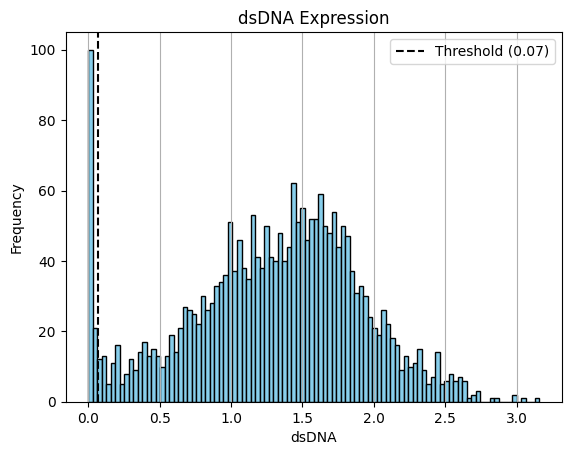

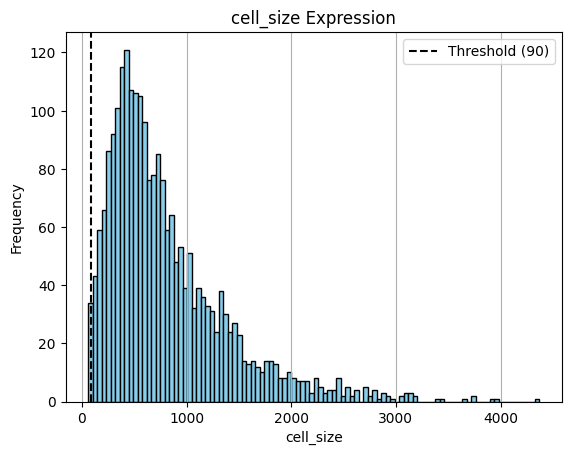

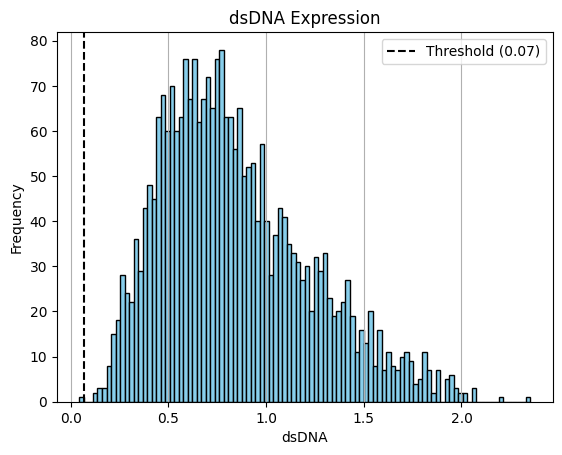

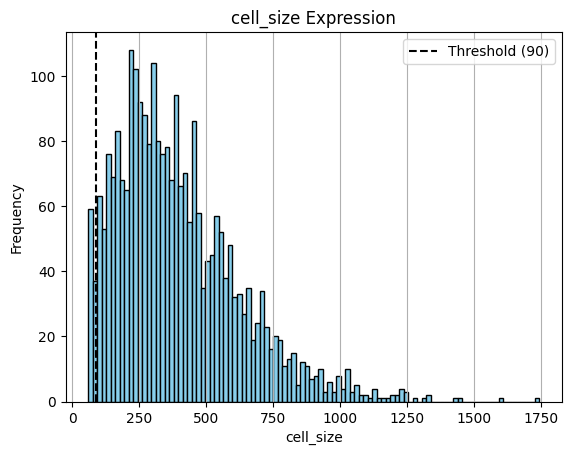

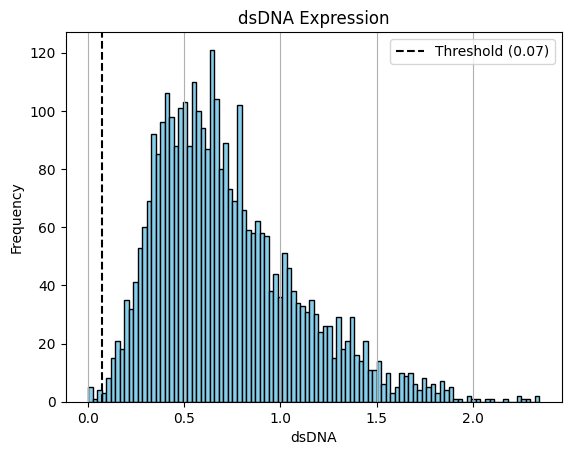

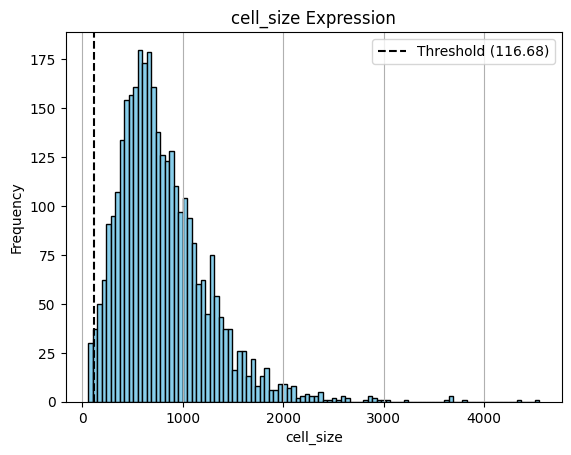

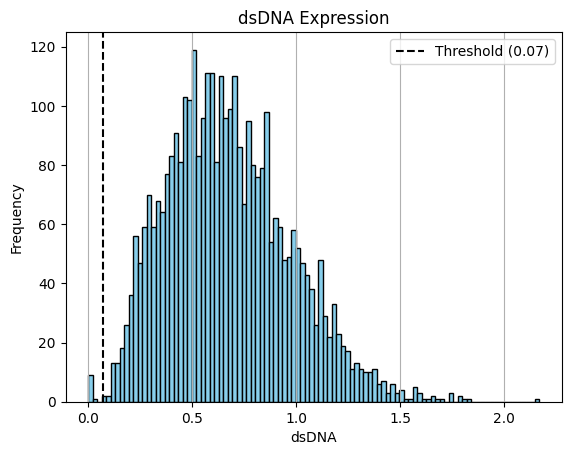

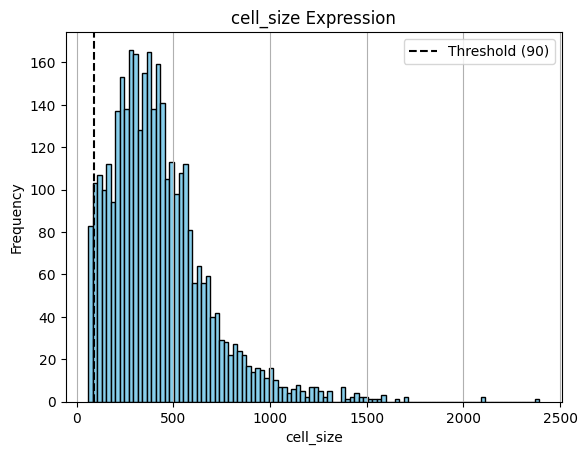

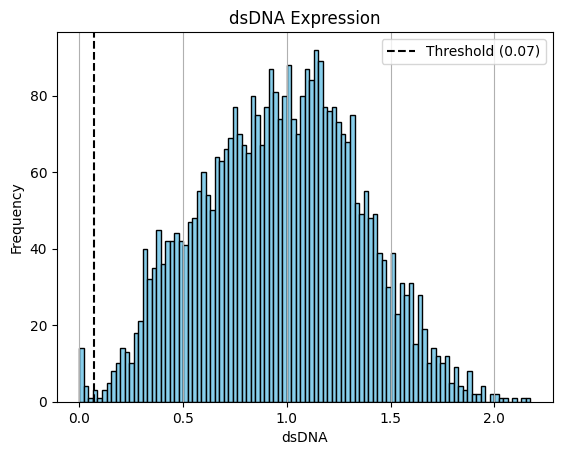

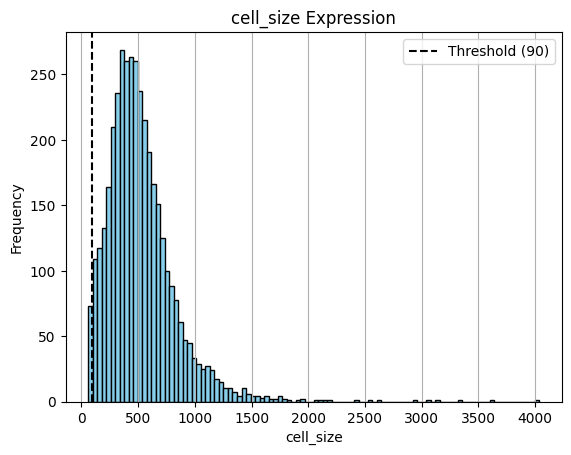

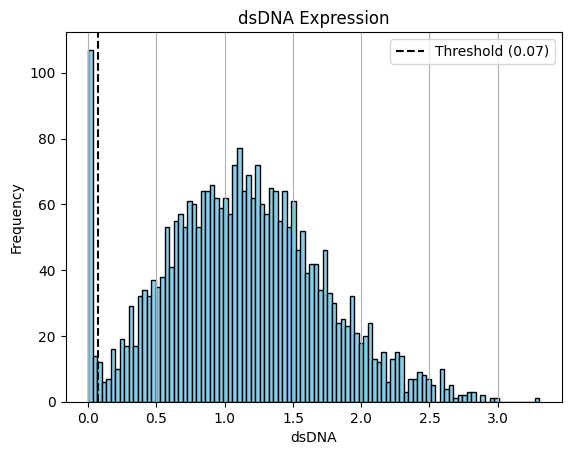

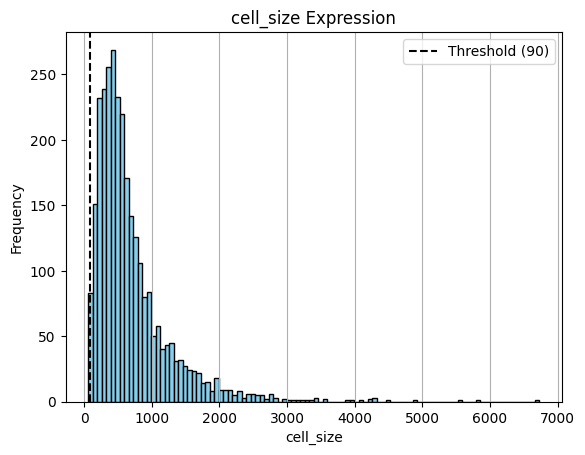

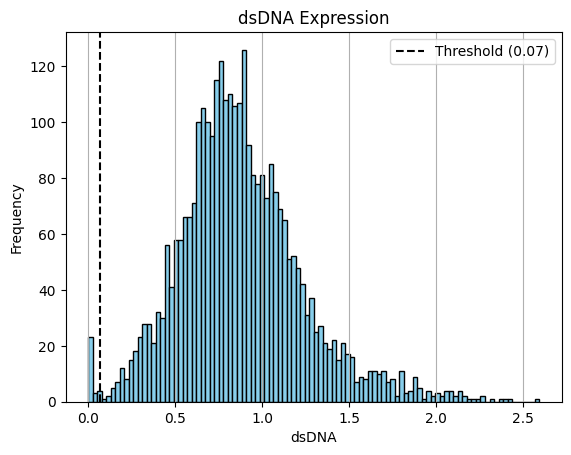

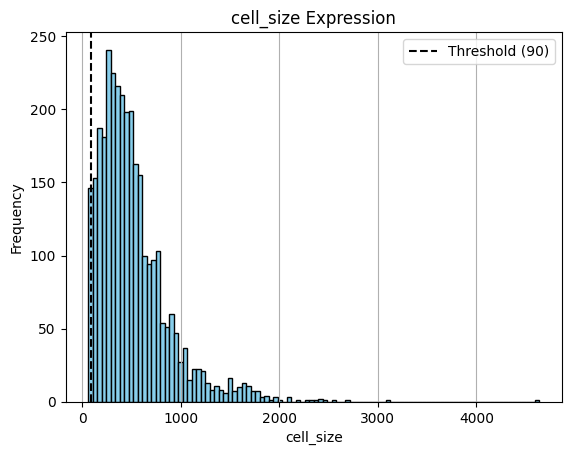

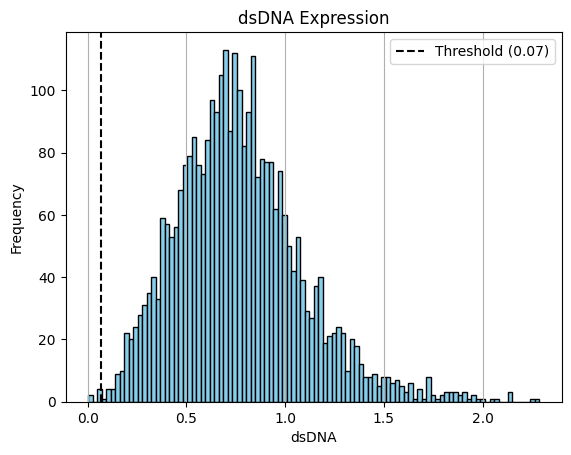

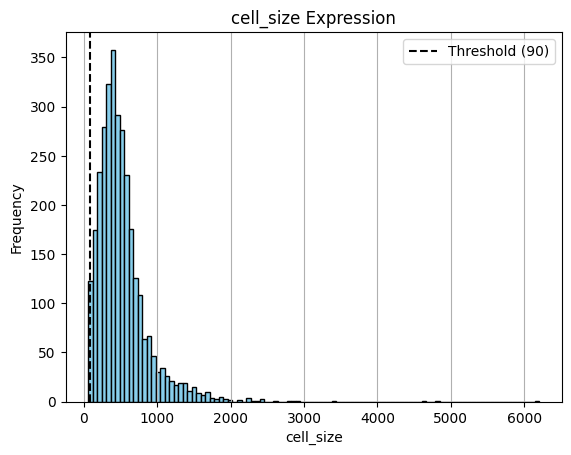

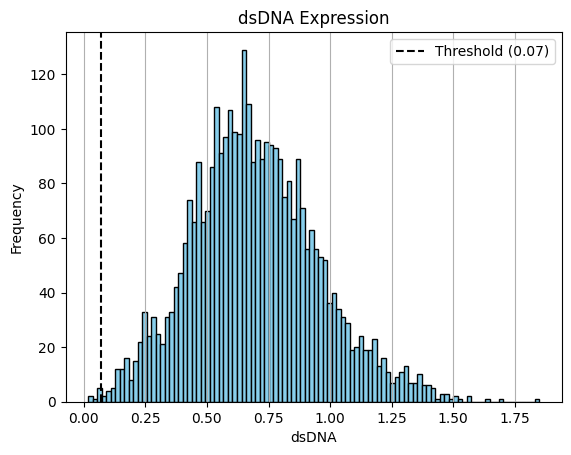

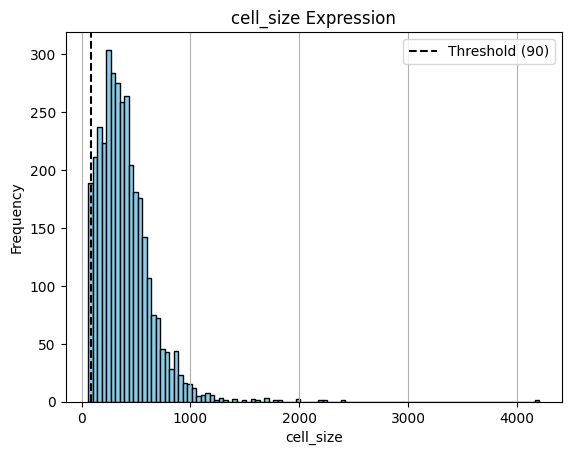

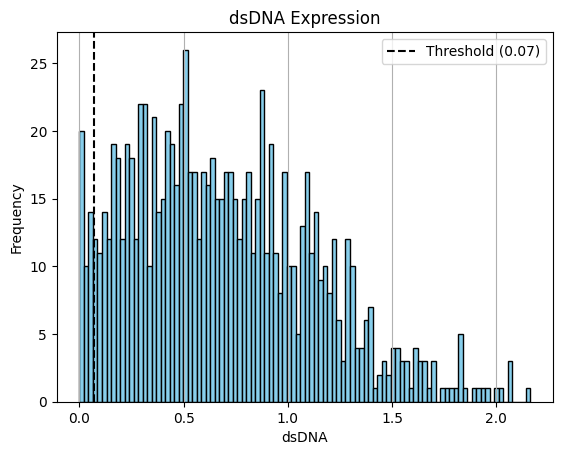

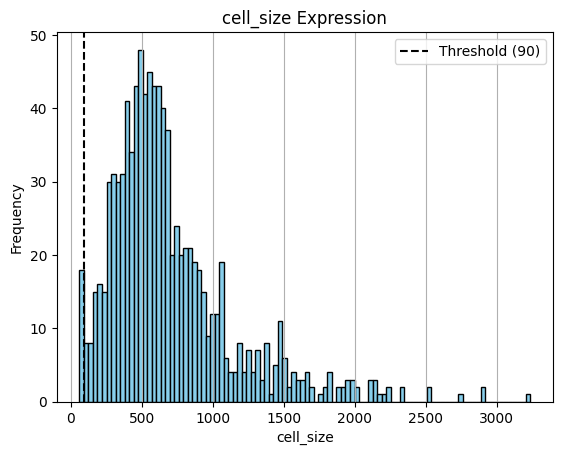

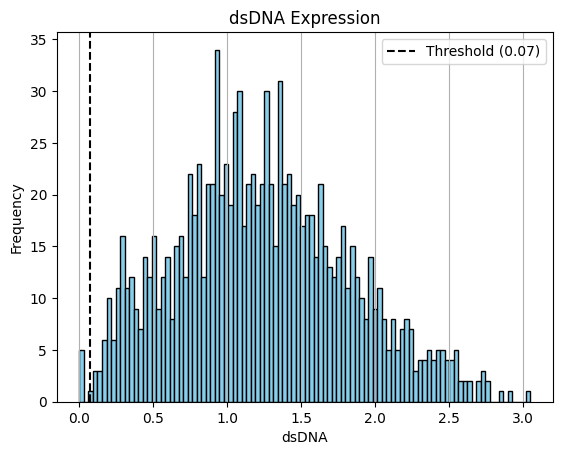

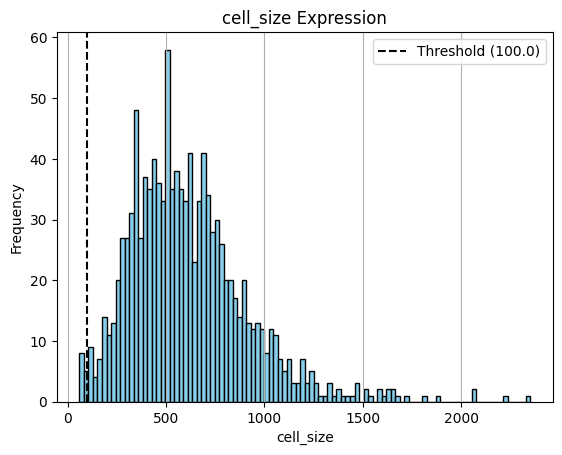

{'29_set7_fov5_TM2-29a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '38_set7_fov7_TM2-38a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '42_set7_fov3_TM2-42a_800um': {'dsDNA': 0.07, 'cell_size': 116.68},
 '50_set4_fov5_TM3-50a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '57_set4_fov2_TM3-57a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '77_set5_fov3_TM9-77a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '82_set5_fov2_TM9-82a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '93_set6_fov2_TM9-93a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '95_set6_fov3_TM9-95a_800um': {'dsDNA': 0.07, 'cell_size': 90},
 '99_set3_fov2_T10-99a-1': {'dsDNA': 0.07, 'cell_size': 90},
 '99_set3_fov3_T10-99a-2': {'dsDNA': 0.07, 'cell_size': 100.0}}

In [5]:
#print(cell_table_df.columns)

dsDNA_threshold = 0.07
filtering_dic = {}

for fov in fovs:
    fov_cell_table_df = cell_table_df[cell_table_df['fov'].str.contains(fov)]
    cell_size_quantile = max(fov_cell_table_df['cell_size'].quantile(0.01), 90)
    expression_explorer(fov_cell_table_df, 'dsDNA', threshold = dsDNA_threshold, save_path='auto')
    expression_explorer(fov_cell_table_df, 'cell_size', threshold = cell_size_quantile, save_path='auto')
    filtering_dic[fov] = {"dsDNA": dsDNA_threshold, "cell_size": cell_size_quantile}

filtering_dic

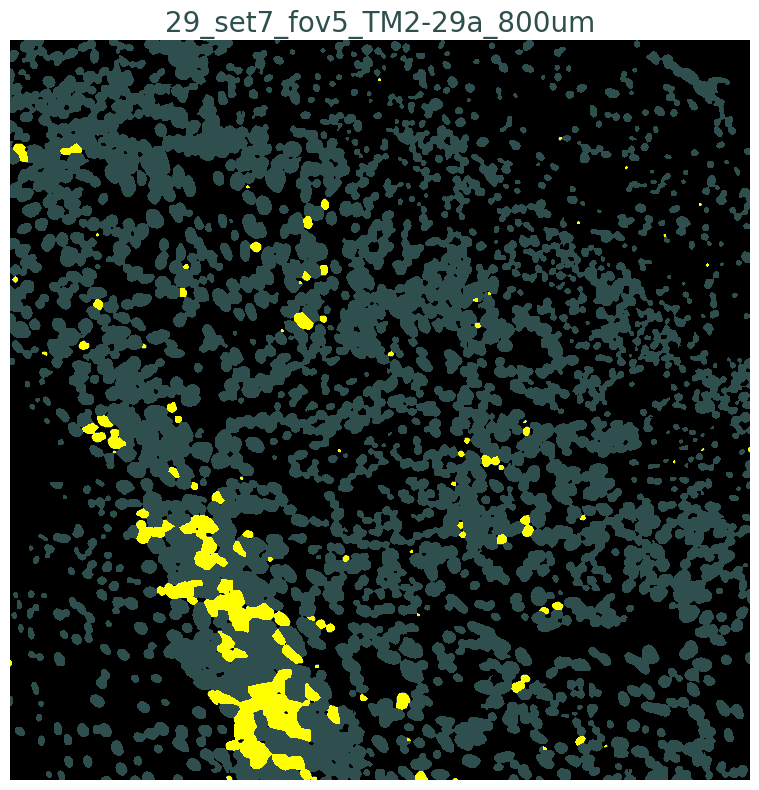

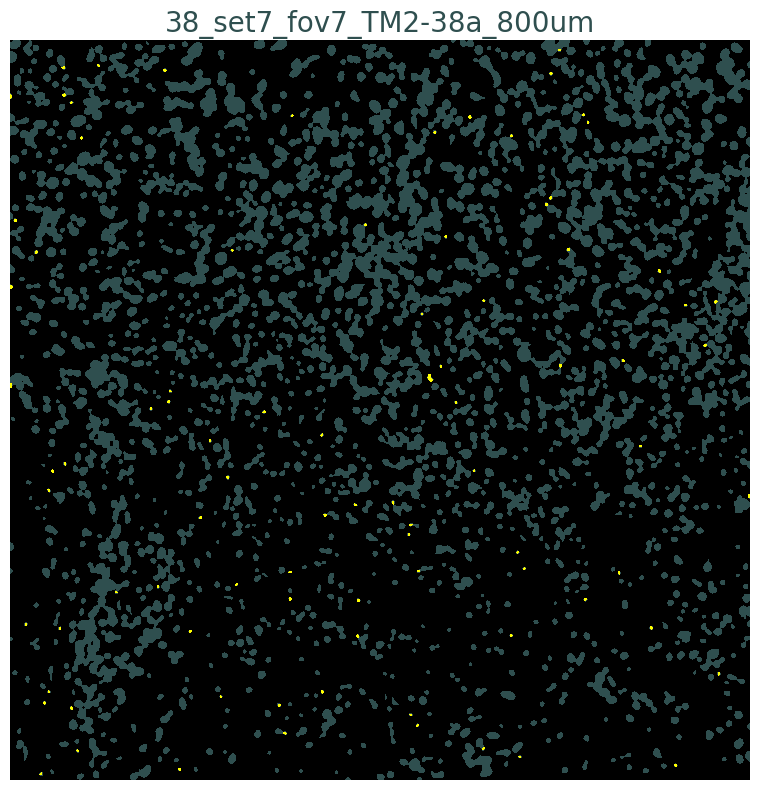

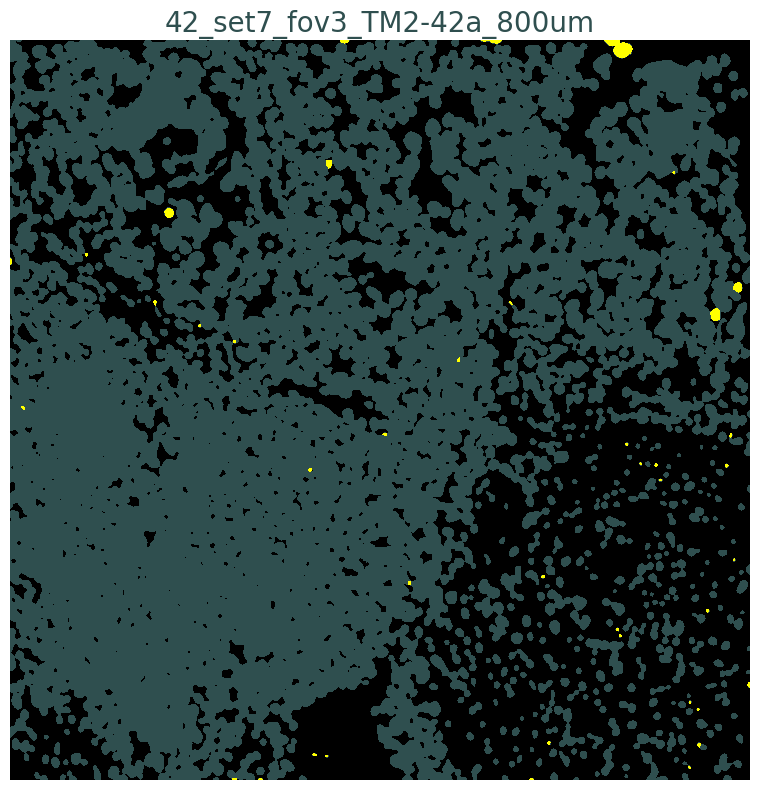

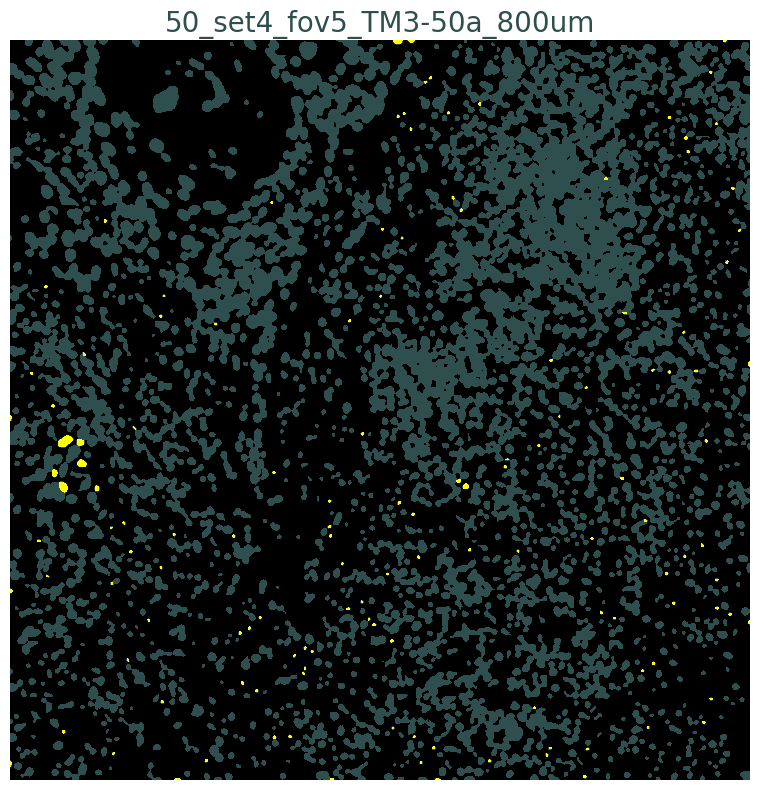

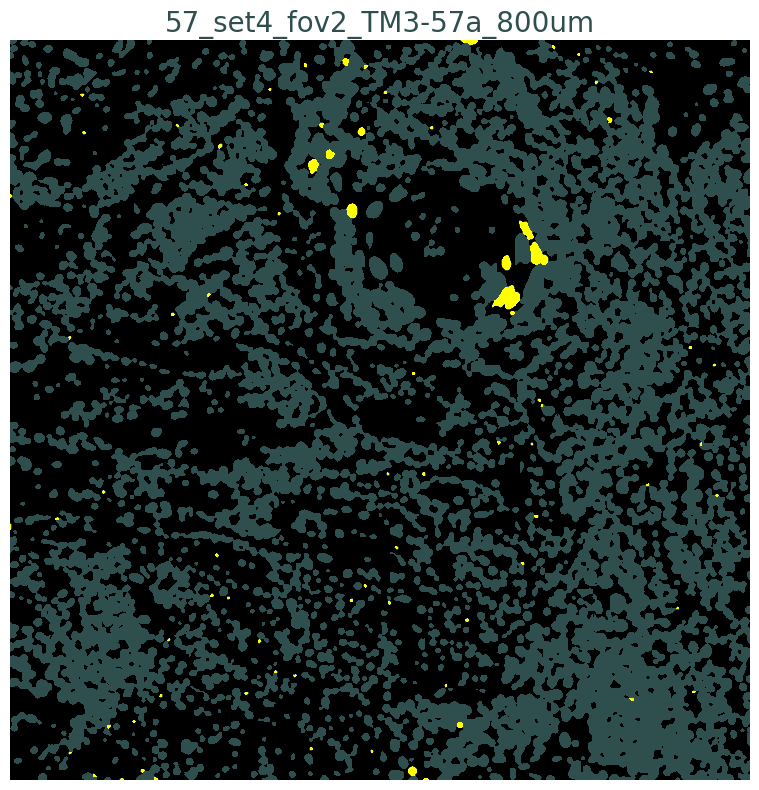

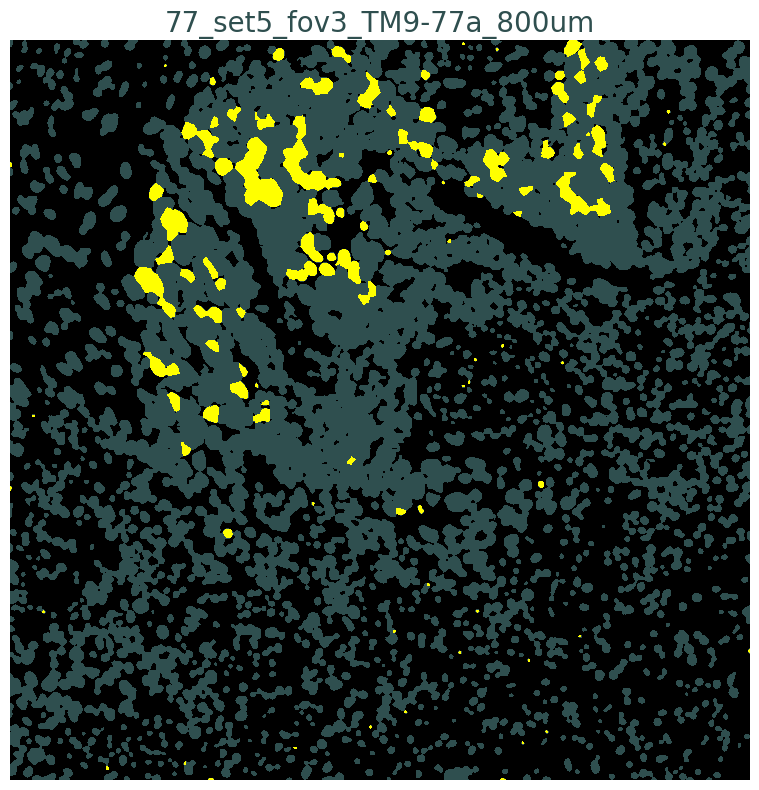

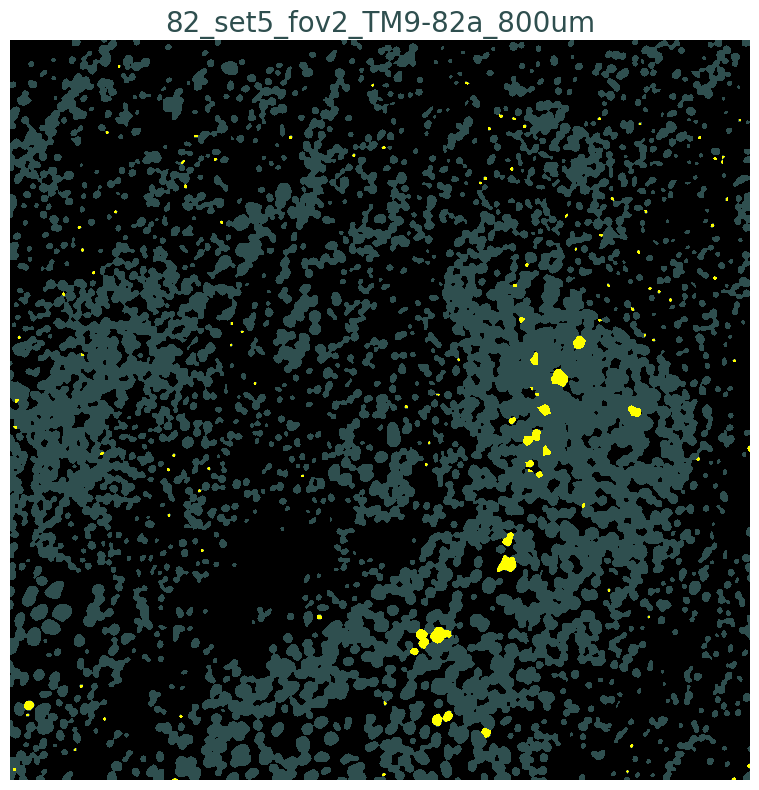

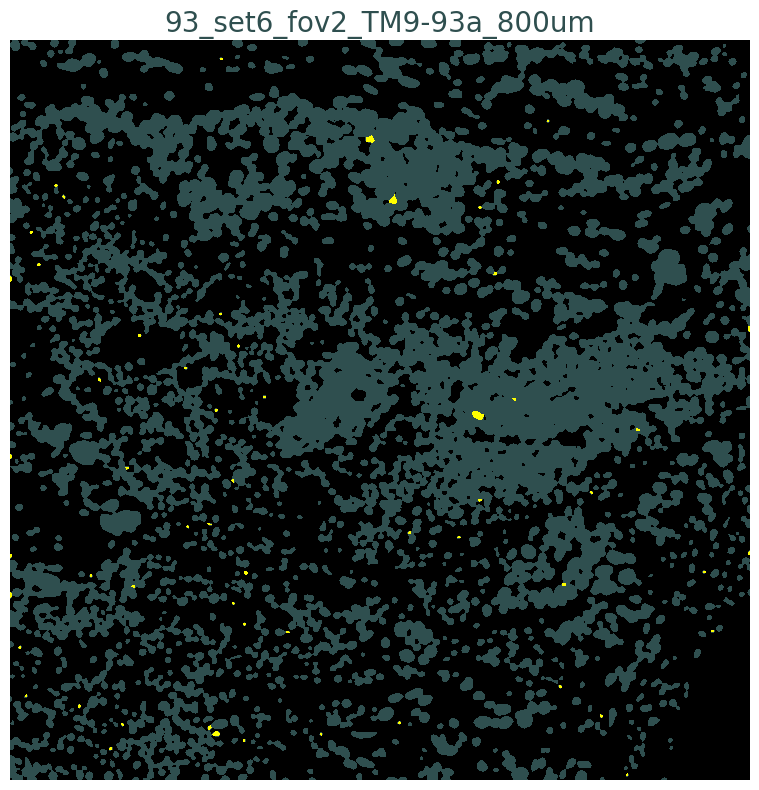

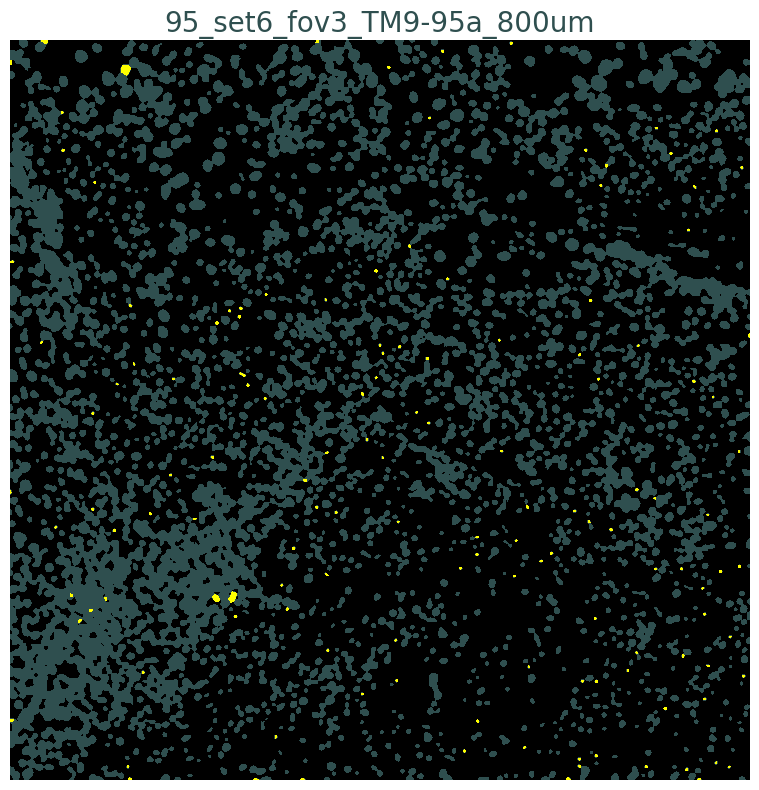

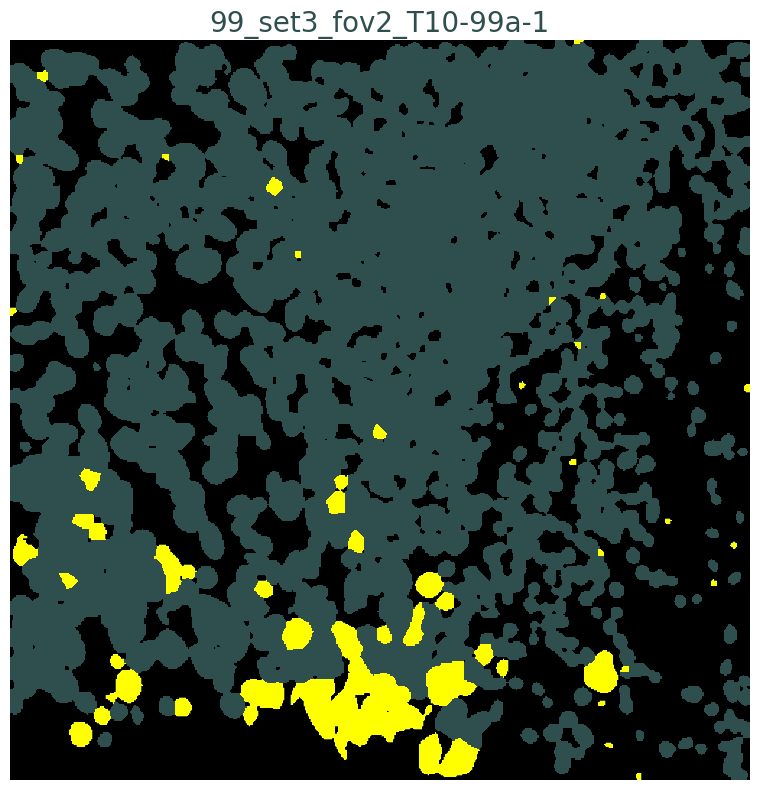

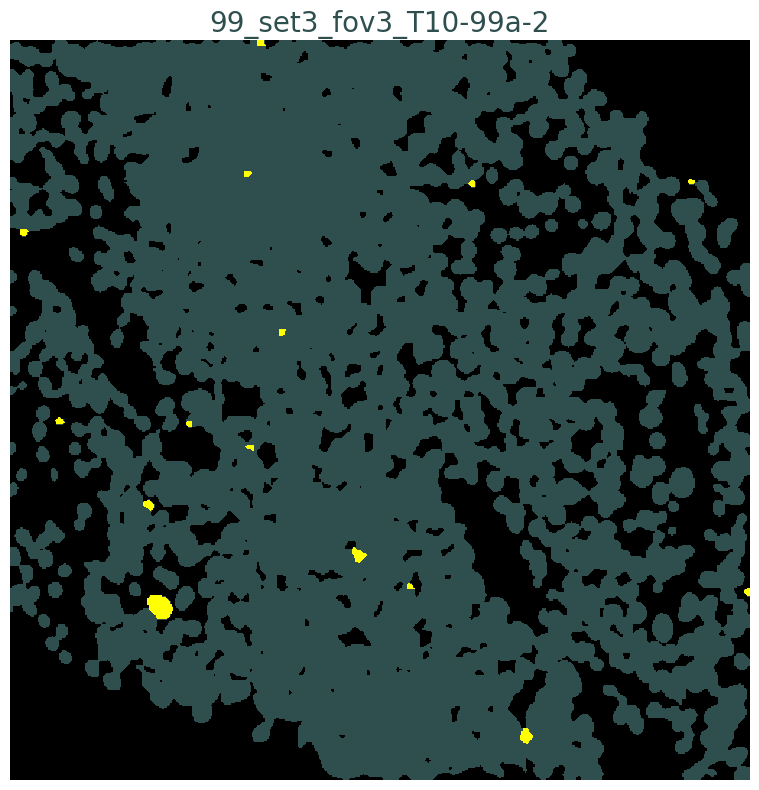

In [6]:
for i, fov in enumerate(fovs):
    cell_mask = "_whole_cell.tiff"
    whole_cell_seg_path = os.path.join(deepcell_output_dir, fov + cell_mask)
    whole_cell_seg_mask_old = np.array(Image.open(whole_cell_seg_path))
    fov_cell_table_df = cell_table_df[cell_table_df['fov'].str.contains(fov)]

    cells_to_remove = []
    for key, value in filtering_dic[fov].items():
        cells_to_remove.extend(fov_cell_table_df[fov_cell_table_df[key] < value]['label'].astype(int).tolist())
    cells_to_remove = list(set(cells_to_remove))

    # Replace cell labels to remove with 0 in the mask
    whole_cell_seg_mask = np.where(np.isin(whole_cell_seg_mask_old, cells_to_remove), 0, whole_cell_seg_mask_old)

    # Save the modified whole cell mask
    wcsm_image = Image.fromarray(whole_cell_seg_mask)
    save_path = os.path.join(curated_deepcell_visualization_path, fov + "_whole_cell.tiff")
    wcsm_image.save(save_path)

    # Visualization using the selected fov to display
    cmap = mcolors.ListedColormap(['black', 'darkslategrey', 'yellow']) 
    # black = background, grey = untouched, yellow = cells removed
    norm = mcolors.Normalize(vmin=0, vmax=2)
    mask_keep = np.zeros_like(whole_cell_seg_mask_old)
    cells_to_keep = set(fov_cell_table_df['label']) - set(cells_to_remove)
    total_cells_n = len(cells_to_keep) + len(cells_to_remove)
    # Write to individual file named after the FOV
    with open(f"{curated_deepcell_visualization_path}/{fov}_output.txt", "w") as file:
        file.write(f"FOV: {fov}\nTotal cells: {total_cells_n}\nCells to keep: {len(cells_to_keep)}\nCells to remove: {len(cells_to_remove)}\n")    
    mask_keep[np.isin(whole_cell_seg_mask_old, list(cells_to_keep))] = 1
    mask_remove = np.where(np.isin(whole_cell_seg_mask_old, cells_to_remove), 2, 0)
    merged_mask = np.maximum(mask_keep, mask_remove)

    plt.figure(figsize = (8,8))
    plt.imshow(merged_mask, cmap=cmap, norm=norm)
    plt.axis('off')
    plt.title(fov, fontsize=20, color='darkslategrey')
    plt.tight_layout()
    save_path = os.path.join(curated_deepcell_visualization_path, fov + "_cell_removal.tiff")
    plt.savefig(save_path, facecolor='black', edgecolor='black')

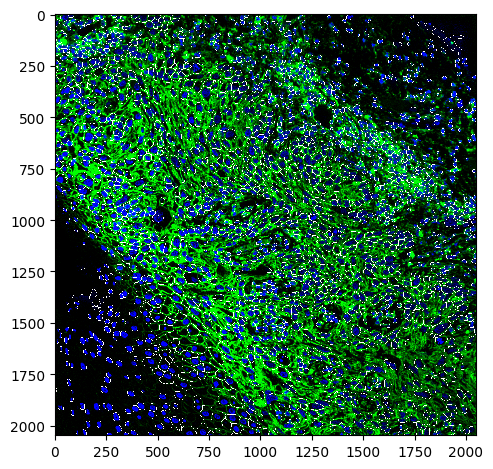

In [22]:
from skimage import io

fov_to_display = io_utils.remove_file_extensions([fovs[0]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=curated_deepcell_output_path,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)

_ = io.imshow(fov_overlay)

curated_deepcell_output_path = os.path.join(base_dir, seg_version, "curated_deepcell_output")
curated_cell_table_path = os.path.join(base_dir, seg_version, "curated_cell_table")
curated_deepcell_visualization_path = os.path.join(base_dir, seg_version, "curated_deepcell_visualization")

In [22]:
# set to True to add nuclear cell properties to the expression matrix
# have to keep this to false right now as I haven't figured out what to do for the nuclear mask.
nuclear_counts = False

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = True

# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=clean_deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fov_vis,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(clean_cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(clean_cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

extracting data from 29_set7_fov5_TM2-29a_800um
extracting data from 38_set7_fov7_TM2-38a_800um
extracting data from 42_set7_fov3_TM2-42a_800um
extracting data from 50_set4_fov5_TM3-50a_800um
extracting data from 57_set4_fov2_TM3-57a_800um
extracting data from 77_set5_fov3_TM9-77a_800um
extracting data from 82_set5_fov2_TM9-82a_800um
extracting data from 93_set6_fov2_TM9-93a_800um
extracting data from 95_set6_fov3_TM9-95a_800um
extracting data from 99_set3_fov2_T10-99a-1
extracting data from 99_set3_fov3_T10-99a-2
